# Inference: Slice Sampling with Stepout
This example shows you how to perform Bayesian inference on a Gaussian distribution and a time-series problem, using
Slice Sampling with Doubling.

First, we create a simple normal distribution.

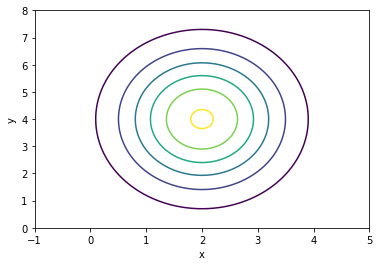

In [2]:
import os
os.chdir("../")
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.GaussianLogPDF([2, 4], [[1, 0], [0, 3]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-1, 5, num_points)
y = np.linspace(-0, 8, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now we set up and run a sampling routine using Slice Sampling with Stepout.

In [3]:
# Choose starting point for 3 mcmc chains
x0 = [
    [2, 4]
]

# Create mcmc routine
mcmc = pints.MCMCController(log_pdf, 1, x0, method=pints.SliceDoublingMCMC)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1000)

for sampler in mcmc.samplers():
    sampler.set_w([0.1, 0.1])
    sampler.set_p(10)
    
# Run!
print('Running...')
chain1 = mcmc.run()
chain2 = mcmc.run()
chain3 = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Doubling
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     1       0:00.0
1     42      0:00.0
2     89      0:00.0
3     137     0:00.0
1000  42770   0:01.4
2000  85370   0:02.7
3000  128347   0:04.2
4000  171174   0:05.6
5000  213874   0:07.2
6000  256393   0:08.5
7000  299070   0:10.0
8000  341904   0:11.5
9000  385010   0:13.0
10000 428113   0:14.6
Halting: Maximum number of iterations (10000) reached.
Using Slice Sampling - Doubling
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     43      0:00.0
1     85      0:00.0
2     137     0:00.0
3     179     0:00.0
1000  42845   0:01.3
2000  85653   0:02.9
3000  128700   0:04.5
4000  171391   0:06.0
5000  214175   0:07.3
6000  256979   0:08.6
7000  299872   0:10.0
8000  342575   0:11.3
9000  385600   0:12.7
10000 428365   0:14.2
Halting: Maximum number of iterations (10000) reached.
Using Slice Sampling - Doubling
Generating 1 chains.
Running in sequent

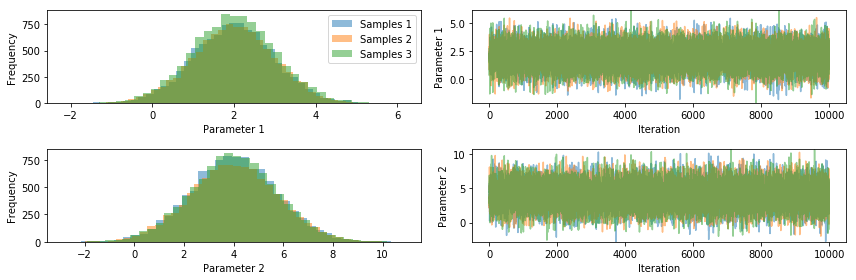

In [4]:
# Show traces and histograms
import pints.plot

chains = np.concatenate((chain1, chain2, chain3))
pints.plot.trace(chains)
plt.show()

R-hat:
[1.0000494695237563, 1.0000704065148742]
0.0006689480535175818
0.0007947724934338485
0.00019338802910850994


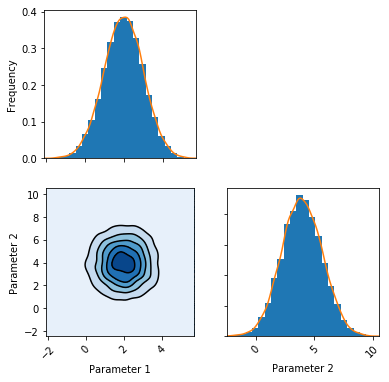

In [8]:
# Discard warm up
chains = chains[:, 200:]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Check Kullback-Leibler divergence of chains
print(log_pdf.kl_divergence(chains[0]))
print(log_pdf.kl_divergence(chains[1]))
print(log_pdf.kl_divergence(chains[2]))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)
plt.show()

# Slice Sampling with Doubling on a time-series problem
We now try the same method on a time-series problem

In [8]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise * 0.1],
    [0.02, 600, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
num_chains = 1
xs = [real_parameters * (1 + 0.1 * np.random.rand())]

# Create mcmc routine
mcmc = pints.MCMCController(
    log_posterior, num_chains, xs, method=pints.SliceDoublingMCMC)
    
# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1000)

# Run!
print('Running...')
chain1 = mcmc.run()
chain2 = mcmc.run()
chain3 = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Doubling
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     1       0:00.0
1     62      0:00.0
2     140     0:00.0
3     198     0:00.0
1000  46671   0:02.9
2000  92868   0:05.9
3000  138922   0:09.0
4000  184991   0:11.8
5000  231175   0:14.9
6000  277695   0:18.0
7000  323648   0:20.7
8000  369832   0:23.4
9000  416026   0:26.1
10000 462139   0:29.0
Halting: Maximum number of iterations (10000) reached.
Using Slice Sampling - Doubling
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     37      0:00.0
1     76      0:00.0
2     129     0:00.0
3     173     0:00.0
1000  46024   0:02.8
2000  91959   0:05.6
3000  138157   0:08.3
4000  184336   0:11.0
5000  229901   0:13.8
6000  275889   0:16.6
7000  322261   0:19.3
8000  368124   0:22.1
9000  414737   0:25.1
10000 460604   0:27.9
Halting: Maximum number of iterations (10000) reached.
Using Slice Sampling - Doubling
Generating 1 chains.
Running in sequent

R-hat:
[0.999961640225614, 0.9999691281544415, 0.9999703677899429]


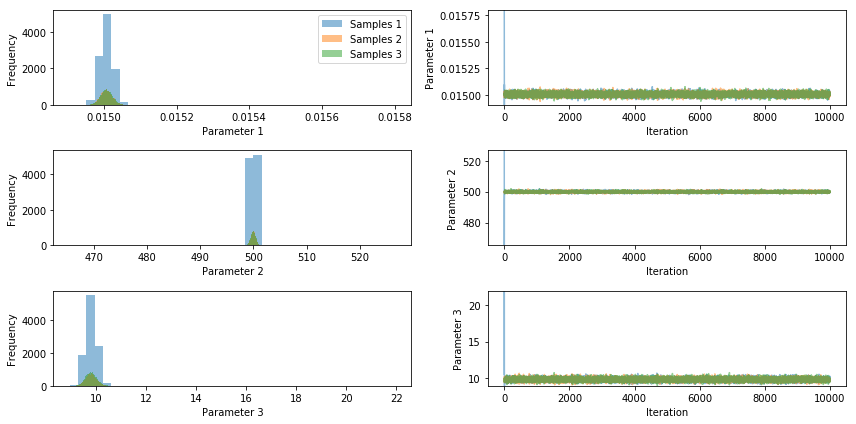

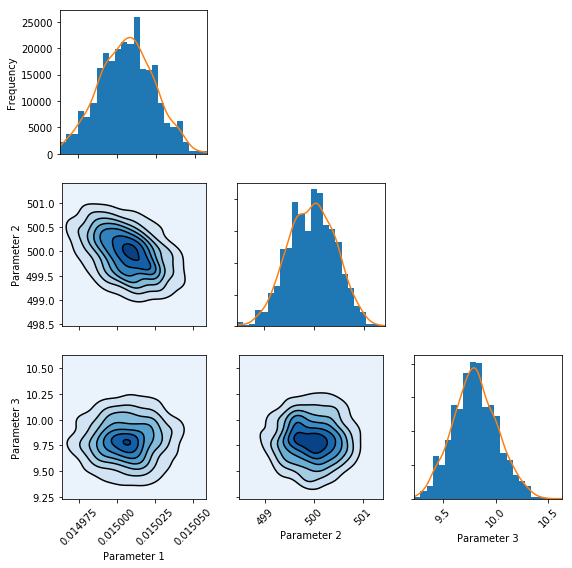

In [9]:
chains = np.concatenate((chain1, chain2, chain3))

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 500:, :]

# Apply thinning
chains = chains[:, ::10]

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)

# Show graphs
plt.show()